In [19]:
import torch
import gpytorch
import random
from gpytorch.likelihoods import GaussianLikelihood, DirichletClassificationLikelihood
from gpytorch.mlls import ExactMarginalLogLikelihood
from botorch.models import SingleTaskGP
from botorch.fit import fit_gpytorch_model
from gpytorch.constraints import Interval
import matplotlib.pyplot as plt
import numpy as np


import matplotlib.pyplot as plt
from botorch.acquisition.monte_carlo import MCAcquisitionFunction
from botorch.acquisition.objective import IdentityMCObjective
from botorch.fit import fit_gpytorch_model
from botorch.models import ModelListGP, SingleTaskGP
from botorch.models.transforms.outcome import Standardize
from botorch.optim import optimize_acqf
from botorch.utils.sampling import sample_hypersphere
from botorch.utils.transforms import t_batch_mode_transform
from gpytorch.constraints import Interval
from gpytorch.likelihoods import GaussianLikelihood
from torch.quasirandom import SobolEngine
from matplotlib import pyplot as plt
from mpl_toolkits import mplot3d
from matplotlib import cm
from alse.eci import ExpectedCoverageImprovement
from alse.gp_model import DirichletGPModel

In [50]:
tkwargs = {
    "device": torch.device("cpu"),
    "dtype": torch.float,
}

            #   width > 2.5   powder capture > 50%           place holder
constraints = [("gt", 2.5),      ("gt", 0.5),    ("gt", 6),     ("gt", 0.1)]

In [39]:
torch.rand(1).item()

0.9042508602142334

In [40]:
import pandas
real_data = pandas.read_excel('~/alse/test_data/4340_3mm_10.47gmin.xlsx')

power = torch.tensor(real_data.loc[:,"P (W)"])
velocity = torch.tensor(real_data.loc[:,"V (mm/min)"])
width = torch.tensor(real_data.loc[:,"widths avg (mm)"]).unsqueeze(-1)
pow_cap = torch.tensor(real_data.loc[:,"powder capt %"]/100).unsqueeze(-1)
height = torch.tensor(real_data.loc[:,"heights avg (mm)"])
width_to_height = width/height.unsqueeze(-1)
width_to_height = torch.nan_to_num(width_to_height, nan = 0.1+torch.rand(1).item())
# torch.nan_to_num(width_to_height)
adhere = (torch.ones(height.shape).bool() & height.bool()).long()
# adhere = torch.stack((adhere, adhere), -1)
X = torch.stack((velocity, power), -1)

[Temporary] Manual scaling

In [41]:
X=X/3000

In [42]:
def get_and_fit_gp(X, Y):
    assert Y.ndim == 2 and Y.shape[-1] == 1
    likelihood = GaussianLikelihood(noise_constraint=Interval(1e-9, 1e-6))  # Noise-free
    gp = SingleTaskGP(X, Y, likelihood=likelihood)
    mll = ExactMarginalLogLikelihood(gp.likelihood, gp)
    fit_gpytorch_model(mll)
    return gp

def identify_samples_which_satisfy_constraints(X, constraints):
    """
    Takes in values (a1, ..., ak, o) and returns (a1, ..., ak, o)
    True/False values, where o is the number of outputs.
    """
    successful = torch.ones(X.shape).to(X)

    these_X = X[..., ]
    direction, value = constraints
    successful[..., ] = (
        these_X < value if direction == "lt" else these_X > value
    )
    return successful

In [43]:
gp_model_width = get_and_fit_gp(X, width)
gp_model_pow_cap = get_and_fit_gp(X, pow_cap)
gp_model_wth = get_and_fit_gp(X, width_to_height)


adhere_likelihood = DirichletClassificationLikelihood(adhere, learn_additional_noise=True)
gp_model_adhere = DirichletGPModel(X, adhere_likelihood.transformed_targets, adhere_likelihood, num_classes=adhere_likelihood.num_classes)

In [58]:
gp_model_adhere.train()
adhere_likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam(gp_model_adhere.parameters(), lr=0.01)  # Includes GaussianLikelihood parameters

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(adhere_likelihood, gp_model_adhere)

for i in range(100):
    # Zero gradients from previous iteration
    optimizer.zero_grad()
    # Output from model
    output = gp_model_adhere(X)
    # Calc loss and backprop gradients
    loss = -mll(output, adhere_likelihood.transformed_targets).sum()
    loss.backward()
    optimizer.step()

RuntimeError: You must train on the training inputs!

In [45]:
N1, N2 = 150, 150
Xplt, Yplt = torch.meshgrid(
    torch.linspace(0, 3000, N1, **tkwargs), torch.linspace(0, 3000, N2, **tkwargs),
    indexing='xy',
)
xplt = torch.stack(
    (
        torch.reshape(Xplt, (Xplt.shape[0] * Xplt.shape[1],)),
        torch.reshape(Yplt, (Yplt.shape[0] * Yplt.shape[1],)),
    ),
    dim=1,
)

In [46]:
predicted_width = gp_model_width(xplt/3000).loc.detach().reshape(N1,N2)
predicted_pow_cap = gp_model_pow_cap(xplt/3000).loc.detach().reshape(N1,N2)
predicted_wth = gp_model_wth(xplt/3000).loc.detach().reshape(N1,N2)

In [47]:
test_point = torch.tensor([[1500,  2600]])
gp_model_width(test_point.float()).loc.detach()

tensor([2.0399])

In [48]:
gp_model_width.covar_module.base_kernel.lengthscale

tensor([[0.4669, 0.4757]], grad_fn=<SoftplusBackward0>)

In [49]:
gp_model_adhere.eval()
with gpytorch.settings.fast_pred_var(), torch.no_grad():
    test_dist = gp_model_adhere(xplt/3000)
    pred_means = test_dist.loc


pred_samples = test_dist.sample(torch.Size((256,))).exp()
probabilities = (pred_samples / pred_samples.sum(-2, keepdim=True)).mean(0)
# probabilities[0] = probabilities[0]*(probabilities[0].max()-probabilities[0].min())
# probabilities[1] = probabilities[1]/probabilities[1].max()
# probabilities[0] = probabilities[0]/probabilities[0].max()
# probabilities[1] = probabilities[1]*(probabilities[1].max()-probabilities[1].min())

predicted_adhere_myway = probabilities.max(0)[1].reshape(N1,N2)
predicted_adhere = pred_means.max(0)[1].reshape(N1,N2)


/opt/conda/lib/python3.9/site-packages/gpytorch/lazy/lazy_tensor.py:1688: UserWarning: torch.triangular_solve is deprecated in favor of torch.linalg.solve_triangularand will be removed in a future PyTorch release.
torch.linalg.solve_triangular has its arguments reversed and does not return a copy of one of the inputs.
X = torch.triangular_solve(B, A).solution
should be replaced with
X = torch.linalg.solve_triangular(A, B). (Triggered internally at  ../aten/src/ATen/native/BatchLinearAlgebra.cpp:2189.)
  Linv = torch.triangular_solve(Eye, L, upper=False).solution


In [51]:
X=X*3000

In [52]:
feasible_inds_width = (
    identify_samples_which_satisfy_constraints(width, constraints[0])
    .prod(dim=-1)
    .to(torch.bool)
)

feasible_inds_pow_cap = (
    identify_samples_which_satisfy_constraints(pow_cap, constraints[1])
    .prod(dim=-1)
    .to(torch.bool)
)
feasible_inds_wth = (
    identify_samples_which_satisfy_constraints(width_to_height.unsqueeze(-1), constraints[2])
    .prod(dim=-1)
    .to(torch.bool)
)
feasible_inds_adhere = (
    identify_samples_which_satisfy_constraints(adhere.unsqueeze(-1), constraints[3])
    .prod(dim=-1)
    .to(torch.bool)
)

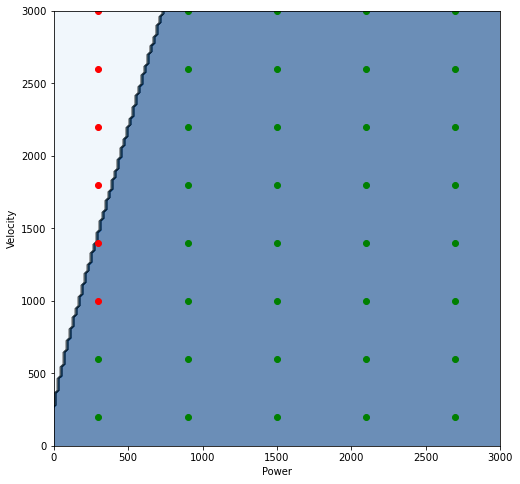

In [57]:
probabilities[0] = probabilities[0]/probabilities[0].max()
probabilities[1] = probabilities[1]*(probabilities[1].max()-probabilities[1].min())

predicted_adhere_myway = probabilities.max(0)[1].reshape(N1,N2)

plt.subplots(figsize=(8, 8))
plt.contourf(Xplt.cpu(), Yplt.cpu(), predicted_adhere_myway.cpu(), cmap="Blues", alpha=0.6)
plt.contour(Xplt.cpu(), Yplt.cpu(), predicted_adhere_myway.cpu(), colors="k", linewidths=0.3)
plt.xlabel("Power")
plt.ylabel("Velocity")
# plt.plot(X[:,0].numpy(), X[:,1].numpy(), "ko")
plt.plot(X[feasible_inds_adhere, 0].cpu(), X[feasible_inds_adhere, 1].cpu(), "og")
plt.plot(X[~feasible_inds_adhere, 0].cpu(), X[~feasible_inds_adhere, 1].cpu(), "or")

ECI Section

In [23]:

punchout_radius = 0.001
bounds = torch.tensor([[200, 200], [3000, 3000]], **tkwargs)
lb, ub = bounds


In [24]:

# # We don't have to normalize X since the domain is [0, 1]^2. Make sure to
# # appropriately adjust the punchout radius if the domain is normalized.

# model_list_gp = ModelListGP(gp_model_width, gp_model_pow_cap, gp_model_adhere)

# eci = ExpectedCoverageImprovement(
#     model=model_list_gp,
#     constraints=constraints,
#     punchout_radius=punchout_radius,
#     bounds=bounds,
#     num_samples=512
# )

# x_next, _ = optimize_acqf(
#     acq_function=eci,
#     bounds=bounds,
#     q=1,
#     num_restarts=10,
#     raw_samples=512
# )
# new_power = round(x_next[0][0].item(), 2)
# new_velocity = round(x_next[0][1].item(), 2)
# print(f"New X: Power: {new_power}W, Velocity: {new_velocity}mm/min")

c:\Program Files\Python310\lib\site-packages\gpytorch\utils\cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
c:\Program Files\Python310\lib\site-packages\gpytorch\utils\cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
c:\Program Files\Python310\lib\site-packages\gpytorch\utils\cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(


New X: Power: 1449.96W, Velocity: 2760.97mm/min


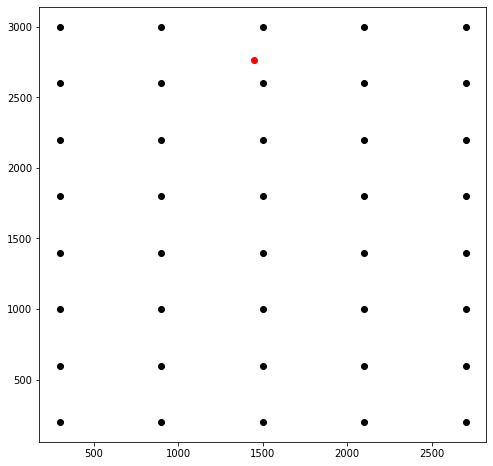

In [25]:
# plt.subplots(figsize=(8, 8))
# plt.plot(X[:,0], X[:,1], "ko")
# plt.plot(x_next[0][0], x_next[0][1], "ro")


In [54]:
est_width = predicted_width > 2.5
est_pow_cap = predicted_pow_cap > 0.5
est_wth = predicted_wth > 6
est_adhere = predicted_adhere

reference = (est_width & est_pow_cap & est_wth & est_adhere)

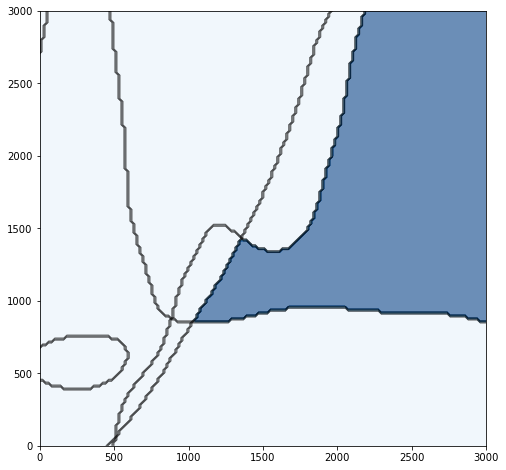

In [56]:
plt.subplots(figsize=(8, 8))
plt.contour(Xplt.cpu(), Yplt.cpu(), est_width.cpu(), colors="k", linewidths=0.3)
plt.contour(Xplt.cpu(), Yplt.cpu(), est_pow_cap.cpu(), colors="k", linewidths=0.3)
plt.contour(Xplt.cpu(), Yplt.cpu(), est_wth.cpu(), colors="k", linewidths=0.3)

plt.contour(Xplt.cpu(), Yplt.cpu(), est_adhere.cpu(), colors="k", linewidths=0.3)
plt.contourf(Xplt.cpu(), Yplt.cpu(), reference.cpu(), cmap="Blues", alpha=0.6)
plt.xlabel('Velocity (mm/min)')
plt.ylabel('Power (W)')